In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf

from pathlib import Path

from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold


from matplotlib.patches import Rectangle
from matplotlib.pyplot import figure



#Seperate file containing custom functions
from my_functions import * 

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Counting the characters

Before we get started with trying to predict the characters, it would be useful to get an idea of how many characters we will be working with. The data set is arranged such that each individual book is a folder with two sub folders and a csv file.

The two sub folders are called 'images' and 'characters'. The 'images' folder contains the actual pages from the book. The 'characters' folder contains several sub directories which correspond to individual written characters (labelled as unicode). Within each sub directory are .jpg files of the individual characters themselves. The csv files contain coordinate information about where each character image is located in each page.

At the moment, we are not interested in the 'images' folders or csv files (we will come back to them). However, we can use the characters sub folders and .jpg files within them to get an initial idea of the data.

By counting the amount of .jpg files in each character sub folder, we can see how many instances of specific characters appear across the books.

In [2]:
#Collect the total amount of unique characters in the books and the amount of each individual character
directory = './all/'
classes = []
observations = []
#images = []
book_id = []
filepaths = []
count =[]

#Traverse through each sub directory in the 'characters' folder 
#skipping the whole pages and coodinate csv files

skip = ["str-images", "str-coordinate"]
for subdir, dirs, files in os.walk(directory):
    count = 0
    if dirs in skip:
            continue
    for filename in files:
        filepath = subdir + os.sep + filename
        #Counting the number of instances of individual characters
        if (filepath.endswith(".jpg")) & ("images" not in filepath):
            count += 1
            filepaths.append(filepath)
            classes.append(Path(subdir).stem)
            book_id.append(Path(subdir).parts[1])
    

In [3]:
book_id
subdir
len(filepaths)
def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True




In [8]:
print("Duplicate files in the dataset: ",checkIfDuplicates_1(filepaths))
print("Total number of characters: ",len(filepaths))



Duplicate files in the dataset:  False
Total number of characters:  1086326


# Preparing the DataFrame

Now, let's tidy up the data into a dataframe to make it more manageable for visualization purposes. In the previous step, we obtained two lists. Firstly, we will create a dataframe listing each instance of each character across each of the books. 

We will also create a dummy variable 'Count' in this dataframe which will make it easier for us to find the total sum of each character across all of the books later.

In [10]:
#Prepare a dataframe to view the total character counts
my_data = pd.DataFrame(columns = ["Book ID","Unicode","File","Count"])

#Add the data as columns to the data frame
classes = pd.Series(classes)
book_id = pd.Series(book_id)
image_files = pd.Series(filepaths)

observations = pd.Series(np.ones(len(filepaths)))


my_data['Unicode'] = classes
my_data['Book ID'] = book_id
my_data['File'] = image_files

my_data['Count'] = observations.astype(int)

my_data_literal = []

for i in range(0,my_data.shape[0]):
    unicode = classes[i]
    my_data_literal.append(chr(int(unicode[2:], 16)))
    
#Add the literal characters as a column to the data frame
my_data.insert(2, "Character", my_data_literal, True) 

#Preview the final data frame
my_data.head(20)



,Book ID,Unicode,Character,File,Count
0,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
1,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
2,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
3,100241706,U+865A,虚,./all/100241706/characters/U+865A/U+865A_10024...,1
4,100241706,U+308C,れ,./all/100241706/characters/U+308C/U+308C_10024...,1
5,100241706,U+308C,れ,./all/100241706/characters/U+308C/U+308C_10024...,1
6,100241706,U+308C,れ,./all/100241706/characters/U+308C/U+308C_10024...,1
7,100241706,U+308C,れ,./all/100241706/characters/U+308C/U+308C_10024...,1
8,100241706,U+308C,れ,./all/100241706/characters/U+308C/U+308C_10024...,1
9,100241706,U+308C,れ,./all/100241706/characters/U+308C/U+308C_10024...,1


In [12]:
#View the total number of individual characters in the data set
print("Total number of characters:",my_data['Count'].sum())

#View the shape of the dataframe
print("Shape of the dataframe: ",my_data.shape)

#Save the dataframe as a csv
my_data.to_csv('kuzushiji_raw.csv', index=False) 

Total number of characters: 1086326
Shape of the dataframe:  (1086326, 5)


---
At the moment the dataframe has seperate rows for the same characters that appear across multiple books. In the next step, we will create a seperate dataframe where the number of character appearances are summed together across all books.

---

In [16]:
#Group the characters by their unicodes to get the total number of apperances for each character across all books
by_kanji = my_data.groupby(["Unicode"])["Count"].sum()

#Seperate the characters and counts into lists
unicodes = by_kanji.index.values.tolist()
total_observations = by_kanji.tolist()

#Create a new dataframe
total_df = pd.DataFrame()
total_df.insert(loc=0, column='Unicode', value=unicodes)

#Create a list to store the literal characters
character_literal = []

#Convert from unicode to literal characters
for i in range(0,len(unicodes)):
    uni = unicodes[i]
    character_literal.append(chr(int(uni[2:], 16)))
    
#Add the literal characters as a column to the data frame
total_df.insert(1, "Character", character_literal, True) 

#Add the counts of each character 
total_df.insert(2,"Count",total_observations)

#Save the new dataframe as a csv
total_df.to_csv('kuzushiji_grouped_by_character.csv', index=False) 

#Preview the new dataframe
total_df.head(20)

,Unicode,Character,Count
0,U+0031,1,2
1,U+0032,2,4
2,U+0034,4,1
3,U+0036,6,1
4,U+0039,9,3
5,U+003F,?,1
6,U+2000B,𠀋,16
7,U+20D45,𠵅,10
8,U+2123D,𡈽,1
9,U+22999,𢦙,4


# Inspecting the data

Now that we have created a dataframe with the total number of character appearances across all books, let's inspect the data to get a better idea of its characteristics. 

In [18]:
#Shape of the dataframe
print("Shape of dataframe: "+str(total_df.shape))
total_char = total_df['Count'].sum()
print("Total characters across all texts: "+str(total_char))

Shape of dataframe: (4328, 3)
Total characters across all texts: 1086326


---
We can see that the dataframe has 4328 rows which means that there are 4328 unique characters which appear across the texts. We can also see that 1,086,326 characters appear across the texts in total. 

---

In [20]:
#Checking to find the most commonly occuring character
most_common = total_df[total_df["Count"] == total_df['Count'].max()]
print(most_common)

rate_of_freq = round(float(most_common['Count']/total_char),5)*100

print(f"\nThe most commonly occuring character accounts for: {rate_of_freq}% of the total observations.")



   Unicode Character  Count
91  U+306E         の  41293

The most commonly occuring character accounts for: 3.801% of the total observations.


---
We can see that the most commonly occuring character の occurs 41,293 times in the data set, which accounts for about 3.8% of the total observations. In modern Japanese this charater is used for a range of different grammatical purposes including: 

Ownership: 
   "this is <b>my</b> computer."
   "He is Luke<b>'s</b> brother."

As an indefinate pronoun:
    "Would you prefer the red <b>one</b>, or the blue <b>one</b>?"

As a prepositional word, similar to the English word 'of':
"The bank <b>of</b> London"

---

<AxesSubplot:>

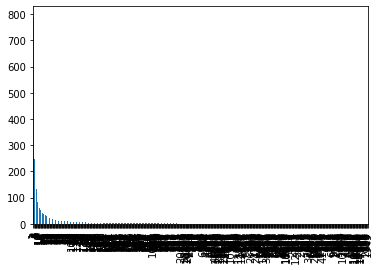

In [21]:
#Frequency plot of the full data set
total_df['Count'].value_counts().plot(kind ='bar')

---
Due to the large number of classes, the above plot is difficult to interpret, but it alludes to problem with this data set. We can see from this plot that while some classes have a large amount of observations, the majority of classes have very few observations. Let's explore this further.

---

In [22]:
#printing summary statistics
print(total_df.describe())


#Investigating the numbers of observations in the classes
total_less_than(1,total_df)

total_less_than(100,total_df)

total_greater_than(2000,total_df)
total_greater_than(30000,total_df)


              Count
count   4328.000000
mean     250.999538
std     1851.491931
min        1.000000
25%        2.000000
50%       10.000000
75%       53.000000
max    41293.000000

Number of characters with 1 or fewer observations: 790
This makes up: 18.25% of the classes

Number of characters with 100 or fewer observations: 3578
This makes up: 82.67% of the classes

Number of characters with 2000 or more observations: 77
This makes up: 1.78% of the classes

Number of characters with 30000 or more observations: 4
This makes up: 0.09% of the classes


In [40]:
#Investigating the top 20 characters with the highest amount of observations
top_20 = total_df.nlargest(20,['Count'])
print(top_20)

#The difference in obsevations between the most frequent and the 20th most frequent
print("\nDifference between the most frequent and 20th most frequent: ",(top_20['Count'].max())-(top_20['Count'].min()))

    Unicode Character  Count
91   U+306E         の  41293
88   U+306B         に  40179
68   U+3057         し  37747
83   U+3066         て  32161
85   U+3068         と  28899
56   U+304B         か  26894
92   U+306F         は  26120
126  U+3092         を  25829
119  U+308A         り  24447
87   U+306A         な  24157
120  U+308B         る  20683
111  U+3082         も  20623
52   U+3044         い  18389
76   U+305F         た  18207
118  U+3089         ら  16582
60   U+304F         く  16242
58   U+304D         き  14549
121  U+308C         れ  13894
107  U+307E         ま  13590
101  U+3078         へ  12797

Difference between the most frequent and 20th most frequent:  28496


Here, we have printed the top 20 most frequent characters in the data set. One thing to note is that all of the characters in the top twenty are "Hiragana" characters. Hiragana characters are used in modern Japanese to write words phonetically and frequently serve grammatical functions such as distinguising a sentence's subject, object, and determining if a sentence is a question or statement.

Hiragana characters are phonetic, and distinct from "Kanji" characters which are ideographic and represent specific ideas/concepts/words. It is therefore not surprising that the top 20 most frequent characters are all Hiragana characters.

We can see that the difference between the most frequent character, の and the 20th most frequent character, へ is 28,496. This demonstrates a tendency to see a rapid drop in character frequency. Below, is a plot showing the frequency of the top 20 most frequent characters visually.

<Figure size 1536x1024 with 0 Axes>

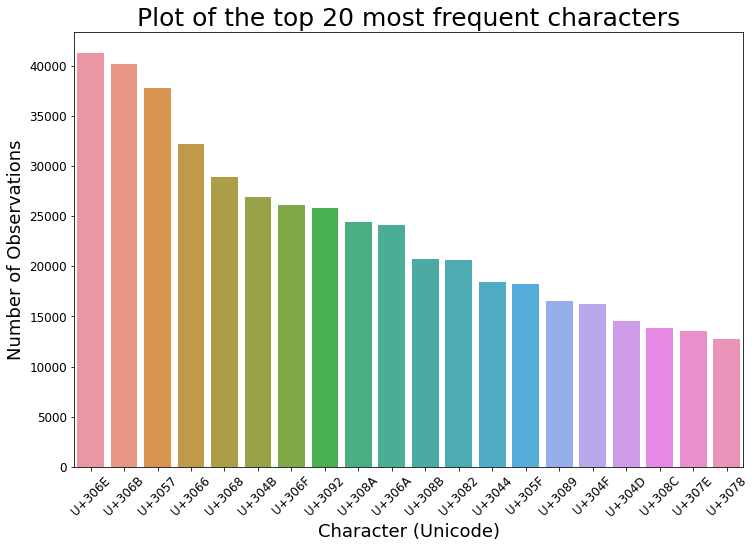

In [41]:
#Plot the top 20 most frequent characters by the amount of observations
figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(12, 8))
top_20_plot = sns.barplot(x = top_20['Unicode'], y = top_20['Count'])

#Adjust the visual parameters of the plot
top_20_plot.axes.set_title("Plot of the top 20 most frequent characters",fontsize=25)
top_20_plot.set_xlabel("Character (Unicode)",fontsize=18)
top_20_plot.set_ylabel("Number of Observations",fontsize=18)
top_20_plot.tick_params(labelsize=12)
plt.setp(top_20_plot.get_xticklabels(), rotation=45)
plt.savefig('top_20_plot.png')

plt.show()

We will now inspect the inter quartile range visually. We can see abover that in terms of character counts, the 75th percentile of character frequency was 53, and the 25th percentile was 2. So we will isolate and investigate the character classes which had between 2 and 53 observations.

In [42]:
#Visualizing the inter quartile range

#Isolate the classes with less than 53 and more than 2 observations
top_iqr = total_df['Count'] <= 53
bottom_iqr = total_df['Count'] >= 2
iqr = total_df[top_iqr & bottom_iqr]

#Sort the values
iqr = iqr.sort_values(['Count'],ascending=False)

#Preview the IQR
print(iqr.head(20))
print("\nTotal amount of characters in the IQR: ",iqr['Count'].sum())
print("\nTotal number of unique characters in the IQR: "+str(iqr.shape[0]))

total_equal_to(53,total_df)
total_equal_to(2,total_df)

#Save a seperate dataframe with only the file lists of characters in the iqr
iqr_raw = my_data[my_data.Unicode.isin(iqr['Unicode'])]
iqr_raw.to_csv('iqr_raw.csv', index=False) 

     Unicode Character  Count
179   U+30D5         フ     53
4059  U+9945         饅     53
629   U+537F         卿     53
287   U+4E7E         乾     53
1036  U+5BA4         室     53
3807  U+9285         銅     53
1611  U+653F         政     53
3560  U+8CCA         賊     53
3253  U+86C7         蛇     53
1401  U+616E         慮     53
3937  U+96D1         雑     53
495   U+518A         冊     52
2302  U+732B         猫     52
3744  U+90E1         郡     52
3928  U+96C1         雁     52
3568  U+8CE2         賢     52
3969  U+9759         静     52
2554  U+796D         祭     52
3678  U+8FF0         述     52
853   U+5805         堅     52

Total amount of characters in the IQR:  32446

Total number of unique characters in the IQR: 2459

Number of characters with 53 observations: 11
This makes up: 0.3% of the classes

Number of characters with 2 observations: 388
This makes up: 9.0% of the classes


---
We can see that the interquartile range consists of 2,459 different classes. Unlike the top 20 most frequent characters, we can see by previewing 20 of the characters in the interquartile range that 19 of them are Kanji characters (which are ideographic and represent words/concepts rather than just sounds). The one exception is the first character in the preview above: "フ"　which is a katakana character mostly used in modern Japanese for the purpose of writing foreign loan words. 

Visualizing the interquartile range in terms of character frequency in a clearly understandable manner poses a challenge. To overcome this, we will group the classes by the number of observations they have, and plot the number of observations, by the number of classes with that number of observations.

For example, there are 11 classes that have 53 observations, and 388 classes that have 2 observations. We will plot this information for each number of observations between 2 and 53.

---

<Figure size 1536x1024 with 0 Axes>

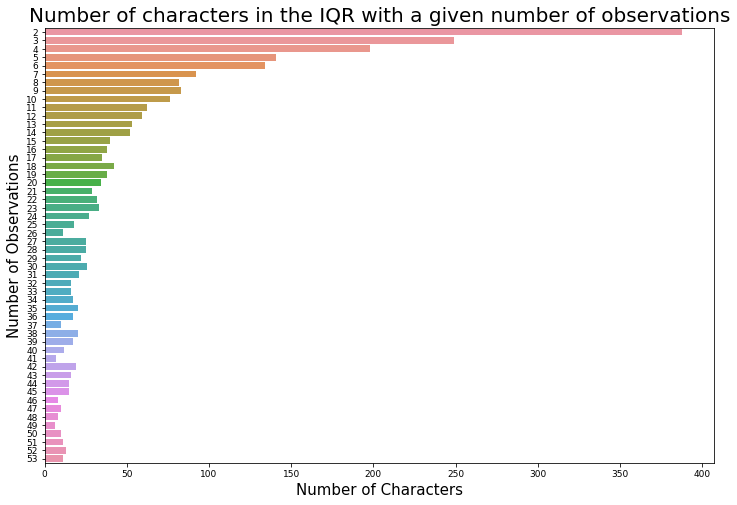

In [47]:
#Group the classes by the amount of observations, showing us how many classes had x observations.
iqr_class_counts = iqr['Count'].value_counts()
iqr_counts = iqr_class_counts.index.values.tolist()
iqr_num_of_classes = iqr_class_counts.tolist()

#Create a plot to visualize the amount of observations each class has within the inter quartile range.

figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(12, 8))
iqr_plot = sns.barplot(x = iqr_num_of_classes, y = iqr_counts, orient='h')

#Adjust the visual parameters of the plot
iqr_plot.axes.set_title("Number of characters in the IQR with a given number of observations",fontsize=20)
iqr_plot.set_xlabel("Number of Characters",fontsize=15)
iqr_plot.set_ylabel("Number of Observations",fontsize=15)
iqr_plot.tick_params(labelsize=9)
plt.savefig('IQR_characters_and_observations.png')

plt.show()

---
This reveals the unbalanced nature of the data. We can see that there are 388 characters with only 2 observations, approximately 250 characters with 3 observations, and appoximately 200 characters with only 4 observations.

This trend continues up until around 15 observations, where the amount of characters, with 15 observations or more, drops and remains below 50, with only 11 characters having 53 observations. We can see below that 1669 characters have 15 or less observations and 790 characters have 15 or more.


In [46]:
#Investigate how many classes in the IQR have 15 observations or more, and how many have less than 15 observations
iqr_freq = iqr.groupby('Count')['Unicode'].size()
iqr_class_counts = iqr['Count'].value_counts()

above_or_equal_to_15 = sum(iqr_class_counts.values[iqr_class_counts.index.values>=15])
below_15 = sum(iqr_class_counts.values[iqr_class_counts.index.values<15])

print(f"Number of classes with 15 observations or more: {above_or_equal_to_15}")
print(f"Number of classes with less than 15 observations: {below_15}")



Number of classes with 15 observations or more: 790
Number of classes with less than 15 observations: 1669


## Conclusion from examining the data

Examining the summary statistics and plots above, we can see that the data is highly unbalanced. While the most frequently occuring character (の) has 41,293 observations, out of the 4,328 characters, 790 of them have only 1 observation (making up 18.25% of the total unique characters). 

Additionally 75% of the unique characters have less than 53 observations. By examining the interquartile range closely, we can also see that 790 characters within the interquartile range have less than 15 observations. When we consider this in combination with the 790 characters with only 1 observation, 1,580 out of the 4,328 unique characters (or approximately 36.51%) have less than 15 observations.

Only 1.78% of the unique characters have 2000 or more observations, with 0.69% of the characters having 10,000 or more observations.

This poses an interesting challenge for the problem. Firstly we will need to consider the implications of working with the full data set as it is. 

As there are 790 character classes with only a single observation, this poses a problem as we would be unable to make sure that these classes are represented in both the training and testing set at the same time. A possible solution would be to generate synthetic data through methods such as image augmentation, and using this synthetic data to train our model, and then testing the model's performance on the real example. However in such a case we would run the risk of overfitting our models as we would be using data in our test set to generate the sythetic data which the model would be trained on. Other ideas would be to only include these classes in our training set, however this would not be particularly useful as we wouldn't be able to test our model's performance on these characters. For these reasons, the character classes with only one observation will not be included when we are building our actual models.

The other thing to consider is the implications for when it comes to balancing our data. As we saw above, we have 388 character classes with only 2 observations each. On the other hand, our most frequent character の has 41,293 observations. Typically when we run a balancing algorithm, the algorithm will produce enough synthetic samples such that the minority classes have the same number of observations as the majority class. However if we consider a case where both the test and training set are assigned approximately 20,000 instances of の each, the amount of computing power required to balance the 4,328 total character classes in the training set would be very demanding. 

For this reason, for the purpose of model building, we will only be working with the classes included in the interquartile range. While it would be ideal to work with all classes in the data set, the IQR reflects the key characteristics of the dataset as a whole (it's highly imbalanced nature) and also primarily consists of less common Kanji characters (as opposed to the frequently occuring Hiragana characters).

---
